# Notebook for the Images classification 

pipeline:
- build the training data set and test data set
- extract the features
- build the classifier
- training and see the accuracy.

In [269]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models,transforms

import pandas as pd
import sklearn

import datasets
from imp import reload 
reload(datasets)

<module 'datasets' from '/Users/shuo/Desktop/Image-Virality/datasets.py'>

## 1. Load the original data set and custom module

`df_subreddit`: the images list used for this this task

`train_data` and `test_data`: the data set loaded from the module `datasets`

In [143]:
df=pd.read_csv('datasets/image4classification.csv')

In [144]:
df.head()

,img_id,SNAP_id,subreddit,label
0,8,10004,funny,0
1,20,10017,gaming,4
2,21,10018,funny,0
3,34,10035,funny,0
4,49,10051,funny,0


In [270]:
train_data=datasets.Reddit_Images_for_Classification('.',transform=transforms.Compose([                      
                       transforms.Resize((224, 224)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]),re_split=True,balance=True)
test_data=datasets.Reddit_Images_for_Classification('.',train=False, transform=transforms.Compose([                      
                       transforms.Resize((224, 224)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]),re_split=True,balance=True)


In [271]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=False)

In [272]:
train_data

Dataset Reddit_Images_for_Classification
    Number of images: 400
    Subreddits: funny, WTF, aww, atheism, gaming 
    Training or Test: train
    Balance or not: True
    Root Location: .
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

## 2. test the function of feature extractor

I defined several feature extractors in the project.

In [37]:
import feature_extractor as extractor

Use the AlexNet to extract the features.

In [76]:
alexnet_ex=extractor.AlexNetExtractor()

In [81]:
img,label=next(iter(train_loader))

In [83]:
# train_data[0][0].size()
output=alexnet_ex(img)

In [84]:
output.size()

torch.Size([64, 256, 6, 6])

Use the VGG network

In [209]:
vgg_model=models.vgg16(pretrained=True)
# vgg_model

In [93]:
output_vgg=vgg_model(img)

In [94]:
output_vgg.size()

torch.Size([64, 512, 7, 7])

Use the resnet18 network

In [109]:
resnet_model=models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/shuo/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:06<00:00, 13202355.36it/s]


In [210]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


# resnet_model

In [111]:
resnet_model.fc=Identity()

In [112]:
output_res=resnet_model(img)

In [113]:
output_res.size()

torch.Size([64, 512])

Use densenet121

In [213]:
model_dense=models.densenet121(pretrained=False)

In [117]:
# model_dense.classifier=Identity()

In [214]:
model_dense

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [119]:
output_dense=model_dense(img)

In [120]:
output_dense.size()

torch.Size([64, 1024])

## 3. do the multi class classification 

Methods:
- sklearn logistics regression (can use the feature extracted from the above models)
- the above algorithms (add the linear layers)
- LightGBM of the above features.
- random forest.

In [132]:
def label_converter(label):
    '''
    Input: the str of label list. '[1,0,0,0,0]'
    return the list of label
    '''
    label=label[1:-1]
    one_hot_label=[int(i) for i in label.split(',')]
    return one_hot_label

If I use the MLP by adding the linear layer, to achieve the multi-class classification. How to define the accuracy?

## 4. test the neural network

train and test the classifier.

In [288]:
import classifier_net as cln
import torch
import torch.nn as nn
import torch.optim as optim

In [297]:
model=cln.cnn_classifier('alexnet',5)

In [298]:
model.freeze()

In [299]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=args.learning_rate,weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

Train

In [302]:
for epoch_i in range(0, 10):
#     running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
#         running_loss += loss.item()
        print(batch_idx,data.size()[0])
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch_i, batch_idx *
            64, len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

0 64
Train Epoch: 0 [0/400 (0%)]	Loss: 3.618893
1 64
Train Epoch: 0 [64/400 (14%)]	Loss: 3.050936
2 64
Train Epoch: 0 [128/400 (29%)]	Loss: 2.345758
3 64
Train Epoch: 0 [192/400 (43%)]	Loss: 2.067535
4 64
Train Epoch: 0 [256/400 (57%)]	Loss: 2.032713
5 64
Train Epoch: 0 [320/400 (71%)]	Loss: 2.354792
6 16
Train Epoch: 0 [384/400 (86%)]	Loss: 2.258650
0 64
Train Epoch: 1 [0/400 (0%)]	Loss: 1.320015
1 64
Train Epoch: 1 [64/400 (14%)]	Loss: 1.123925


KeyboardInterrupt: 

Test

In [260]:
import visualisation as vis

In [273]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [274]:
model.eval()
out=model(images)

In [275]:
_, predicted = torch.max(out, 1)

In [276]:
predicted

tensor([2, 4, 1, 3, 0, 3, 1, 2, 4, 2, 2, 3, 3, 3, 2, 1, 1, 0, 0, 1, 1, 2, 2, 3,
        1, 2, 3, 1, 2, 0, 0, 2, 0, 3, 1, 2, 4, 3, 0, 2, 0, 0, 2, 0, 1, 3, 1, 2,
        0, 3, 2, 1, 3, 1, 4, 3, 1, 0, 2, 0, 1, 2, 2, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


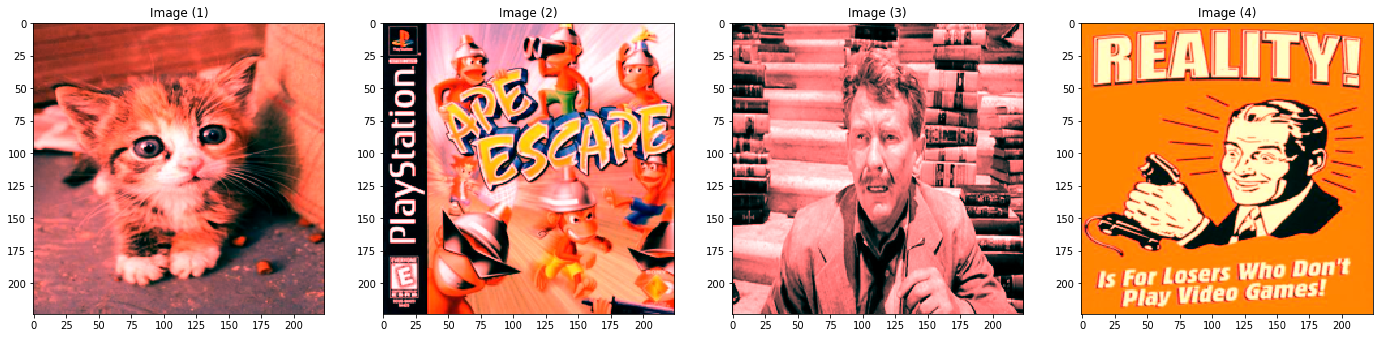

In [261]:
vis.show_images(images[:4])